In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

plt.rcParams.update({
    "font.size": 14,           # base font size
    "axes.titlesize": 14,      # title font
    "axes.labelsize": 14,      # x/y label font
    "xtick.labelsize": 14,     # x-axis tick font
    "ytick.labelsize": 14,     # y-axis tick font
    "legend.fontsize": 14
})

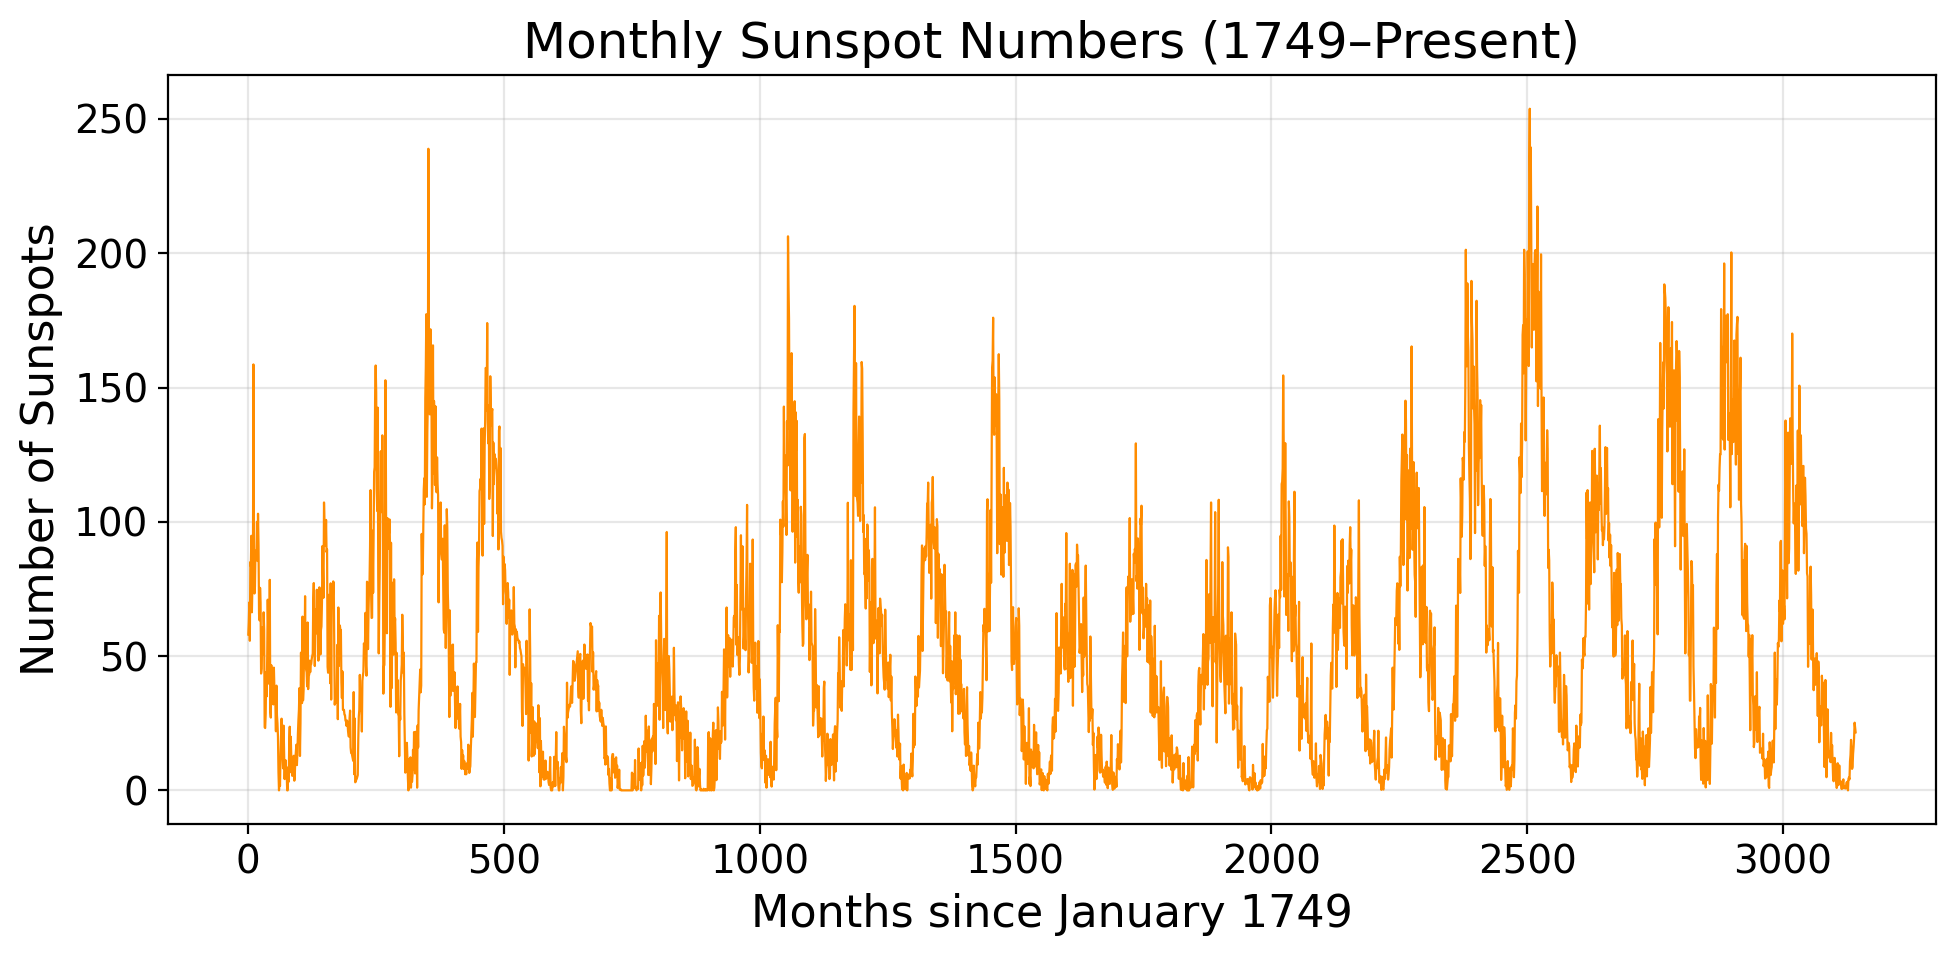

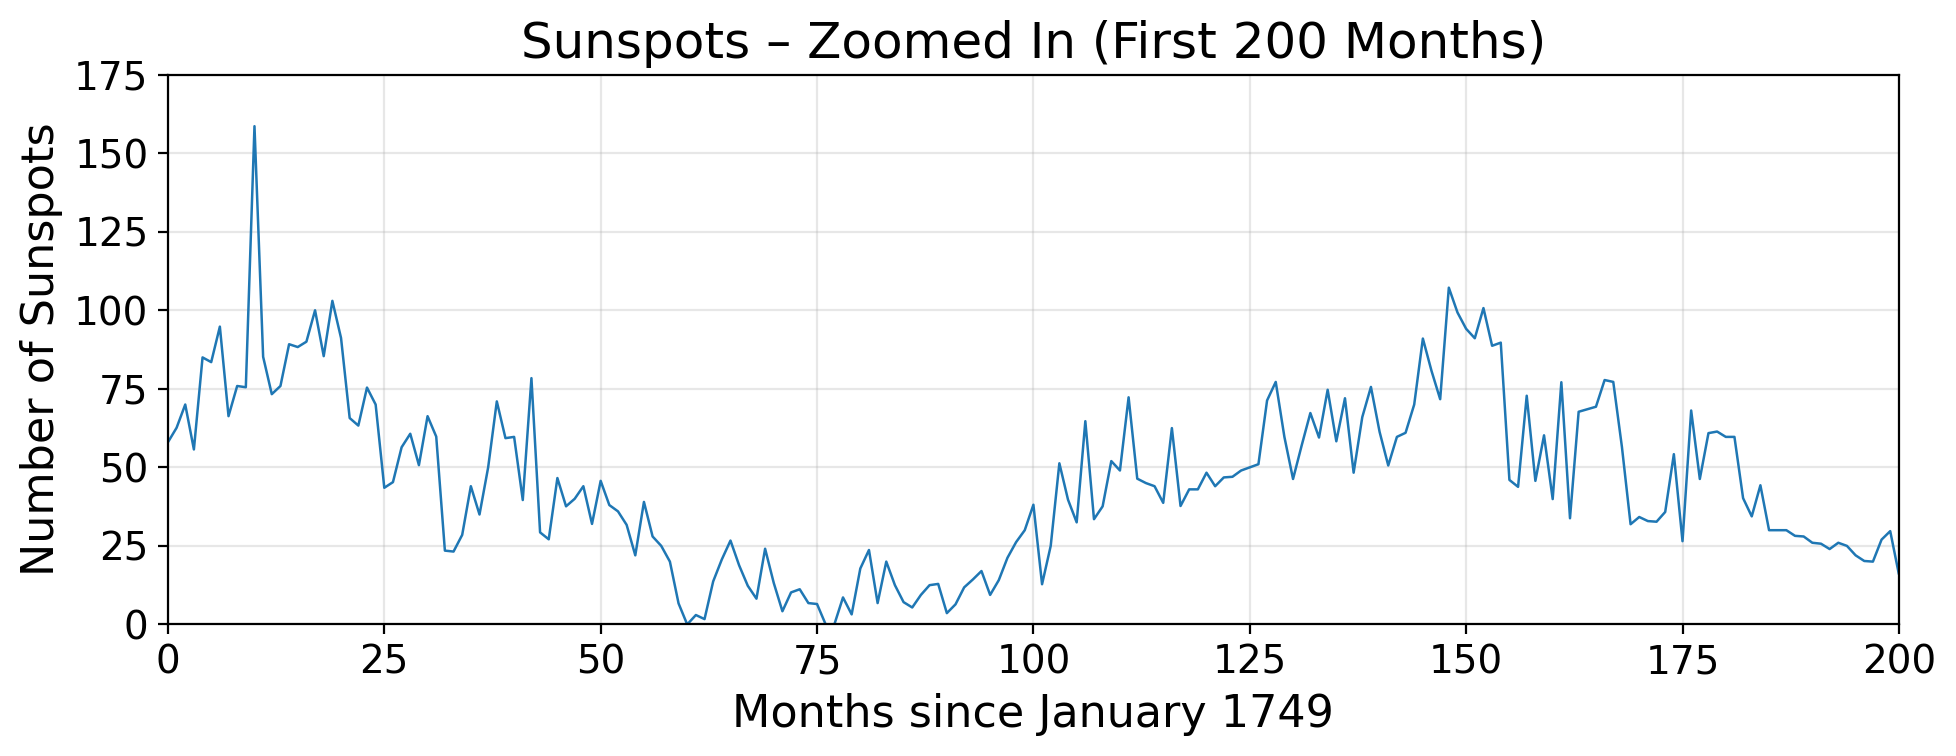

In [66]:
### Problem 1

data = np.genfromtxt("sunspots.txt")
months = data[:,0]
spots = data[:,1]

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(months, spots, color='darkorange', linewidth=0.8)
plt.title("Monthly Sunspot Numbers (1749–Present)", fontsize=18)
plt.xlabel("Months since January 1749", fontsize=16)
plt.ylabel("Number of Sunspots", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
#zoom in
plt.figure(figsize=(10, 4), dpi=200)
plt.plot(months, spots, color='tab:blue', linewidth=0.9)
plt.title("Sunspots – Zoomed In (First 200 Months)", fontsize=18)
plt.xlabel("Months since January 1749", fontsize=16)
plt.ylabel("Number of Sunspots", fontsize=16)
plt.xlim(0, 200)
plt.ylim(0,175)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
## from plot we estimate period to be around 130 months.

Dominant frequency: 0.007636016544702513
Period (months): 130.95833333333334


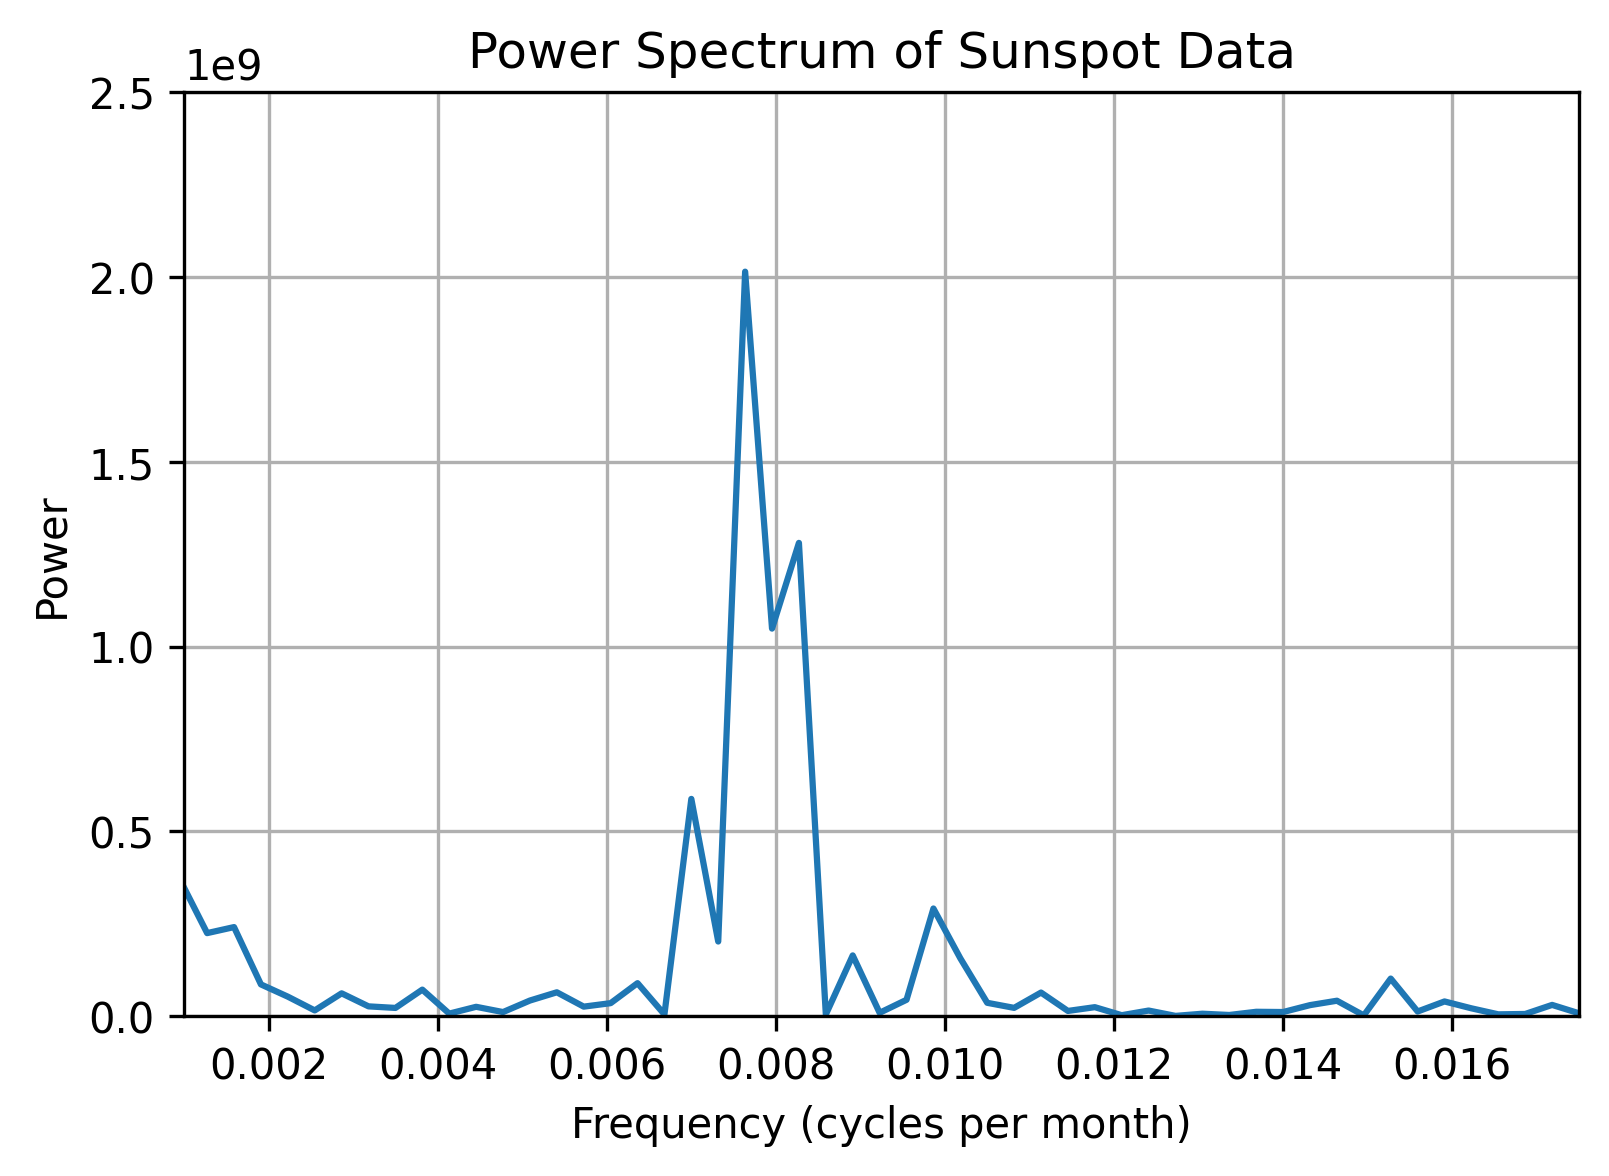

In [59]:
# do FFT
N = len(spots)
d = months[1] - months[0]   # sample spacing (≈ 1 month)
cs = np.fft.fft(spots)
freq = np.fft.fftfreq(N, d=d)
shifted_fft = np.fft.fftshift(cs)
freq_shifted = np.fft.fftshift(freq)
power = np.abs(shifted_fft)**2

plt.figure(figsize=(6,4), dpi=300)
plt.plot(freq_shifted, power)
plt.title("Power Spectrum of Sunspot Data")
plt.xlabel("Frequency (cycles per month)")
plt.ylabel("Power")
plt.xlim(0.001, 0.0175)
plt.ylim(0,2.5e9)
plt.grid(True)

# find the main peak
mask = (freq_shifted > 0.001) & (freq_shifted < 0.0175)
peaks, _ = find_peaks(power[mask])
freq_peaks = freq_shifted[mask][peaks]
power_peaks = power[mask][peaks]

f_peak = freq_peaks[np.argmax(power_peaks)]
period = 1 / f_peak
print("Dominant frequency:", f_peak)
print("Period (months):", period)